# SuperVoice vocoder evaluation
This notebook provides tools for HiFi-GAN vocoder evaluation

In [1]:
# Base
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Local
from model import HiFiGAN
from dataset import spectogram, load_mono_audio

### Environment

In [2]:
# Parameters
device = torch.device('cpu')
vocoder_resblock = "1"
vocoder_upsample_rates = [5,4,4,2]
vocoder_upsample_kernel_sizes = [11,8,8,4]
vocoder_upsample_initial_channel = 512
vocoder_resblock_kernel_sizes = [3,7,11]
vocoder_resblock_dilation_sizes = [[1,3,5], [1,3,5], [1,3,5]]
vocoder_mel_n = 80
vocoder_mel_fft = 1024
vocoder_mel_hop_size = 160
vocoder_mel_win_size = 640
vocoder_sample_rate = 16000
checkpoint = "./output/pre.pt"

# Device and Model
generator = HiFiGAN(
    mels_n=vocoder_mel_n,
    resblock=vocoder_resblock,
    upsample_rates=vocoder_upsample_rates,
    upsample_kernel_sizes=vocoder_upsample_kernel_sizes,
    upsample_initial_channel=vocoder_upsample_initial_channel,
    resblock_kernel_sizes=vocoder_resblock_kernel_sizes,
    resblock_dilation_sizes=vocoder_resblock_dilation_sizes,
).to(device)

# Load checkpoint
data = torch.load(checkpoint, map_location=device)
generator.load_state_dict(data['generator'])
generator.eval()
generator.remove_weight_norm()

# Tools
def plot_waveform(waveform, sample_rate=16000, title="Waveform", xlim=(0,5)):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(15, 8))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

def plot_specgram(spectrogram, title="Spectrogram"):
    _, axis = plt.subplots(1, 1, figsize=(15, 8))
    axis.imshow(spectrogram, cmap="viridis", vmin=-10, vmax=0, origin="lower", aspect="auto")
    axis.set_title(title)
    plt.tight_layout()

Removing weight norm...


# Evaluation

In [3]:
# Custom file
from ipywidgets import FileUpload
upload = FileUpload(multiple=False)
upload

FileUpload(value=(), description='Upload')

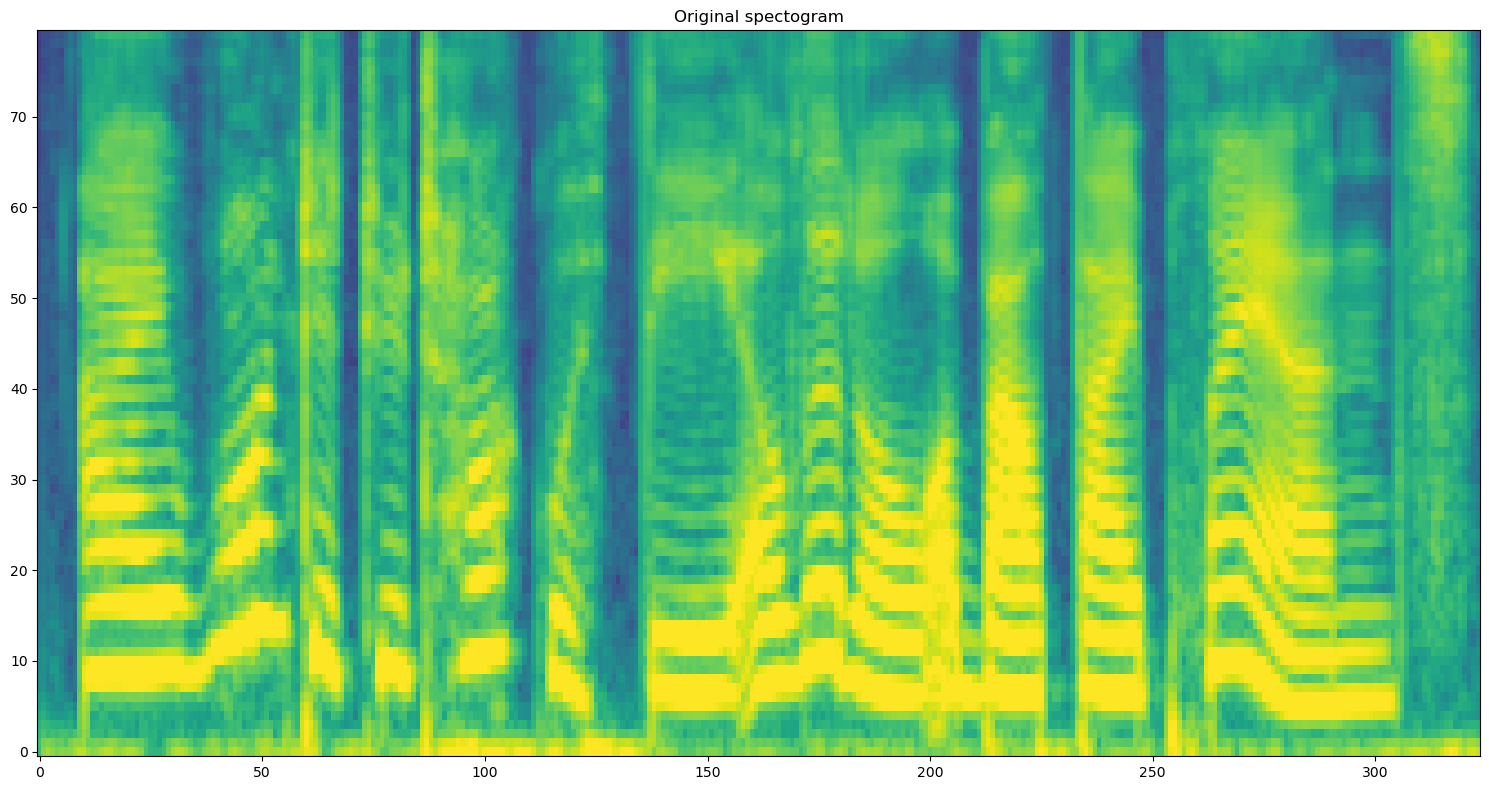

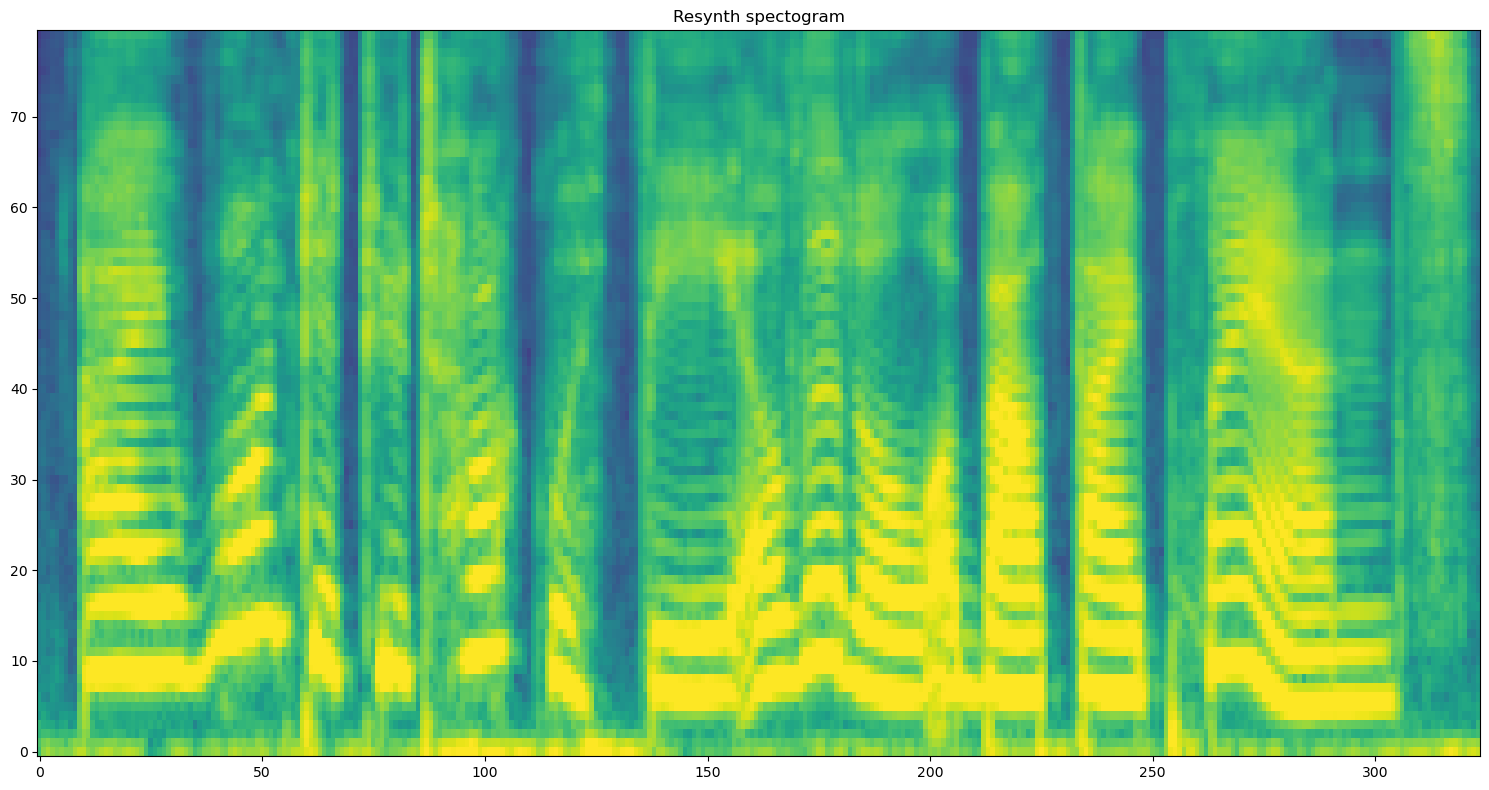

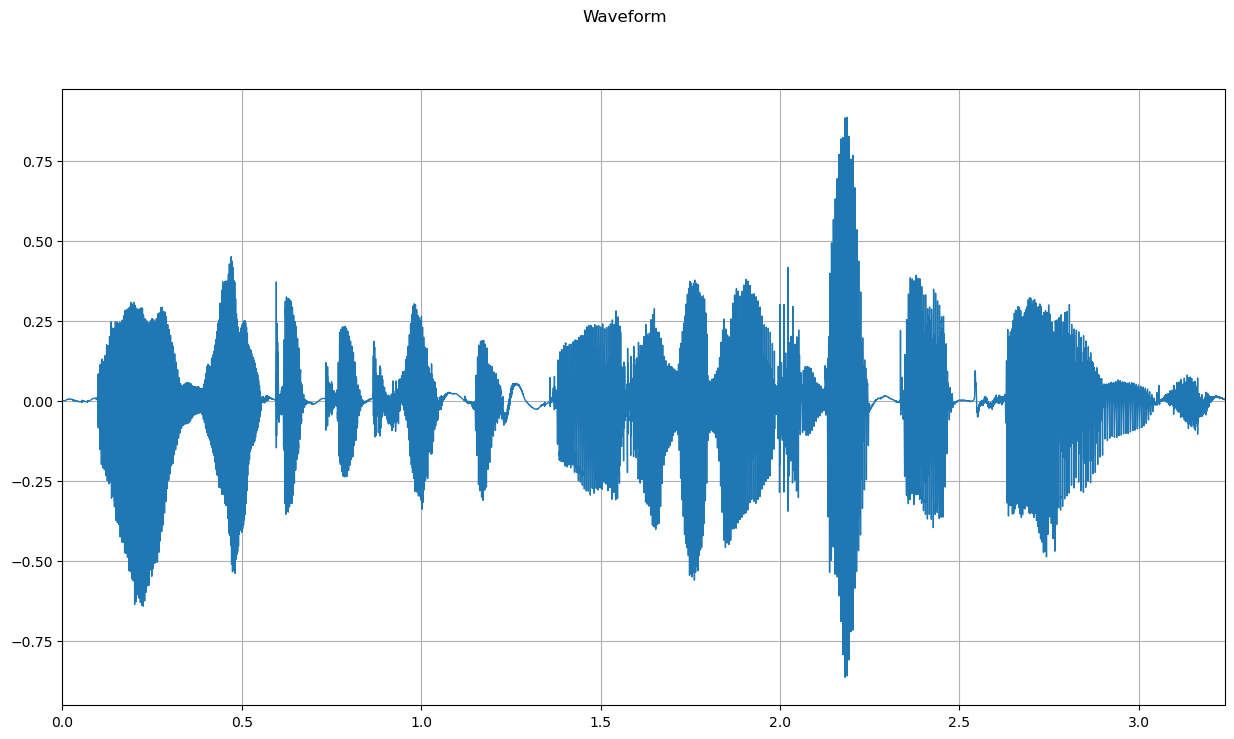

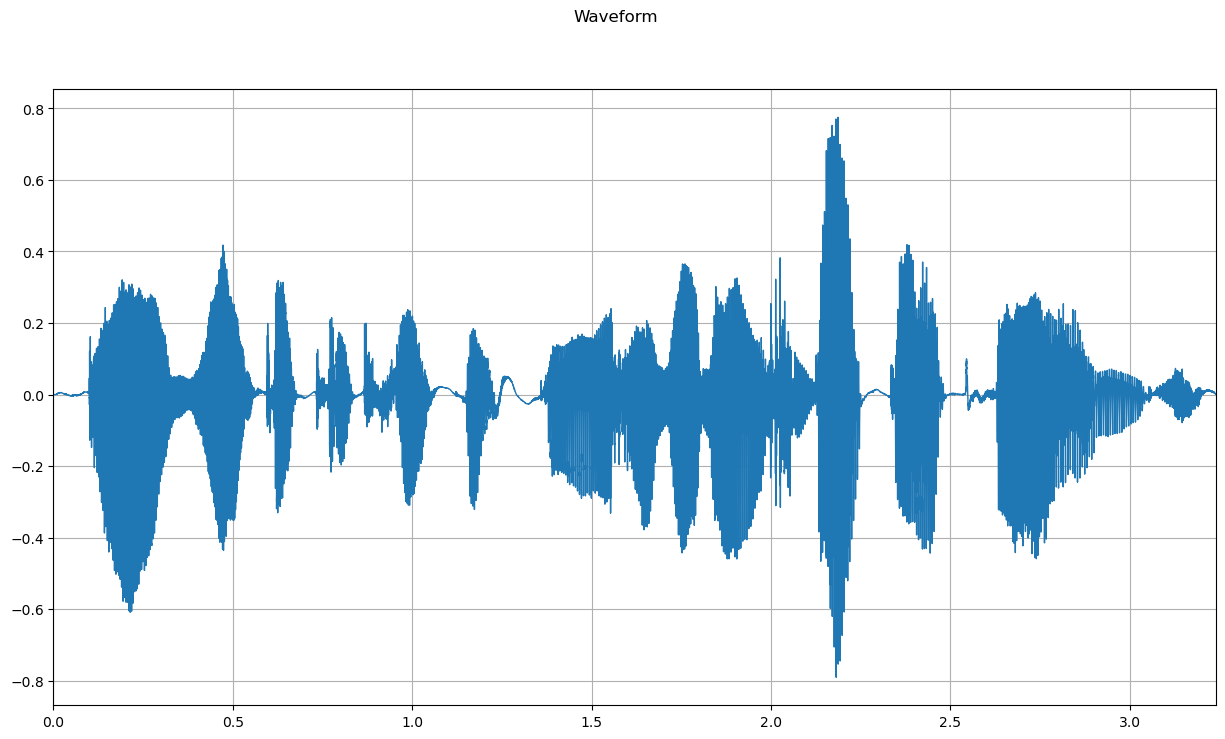

In [4]:
# Load
if len(upload.value) == 1:
    with open("eval_vocoder.out", "w+b") as i:
        i.write(upload.value[0].content)
    test = load_mono_audio("eval_vocoder.out", vocoder_sample_rate)
else:
    test = load_mono_audio("./external_datasets/libritts-r/test-clean/4970/29095/4970_29095_000006_000000.wav", vocoder_sample_rate)
spec = spectogram(test, vocoder_mel_fft, vocoder_mel_n, vocoder_mel_hop_size, vocoder_mel_win_size, vocoder_sample_rate)

# Generate
resynth = generator(spec.unsqueeze(0).to(device)).detach().cpu().squeeze(0)
resynth_spec = spectogram(resynth, vocoder_mel_fft, vocoder_mel_n, vocoder_mel_hop_size, vocoder_mel_win_size, vocoder_sample_rate).squeeze(0)

# Source
plot_specgram(spec, title="Original spectogram")
plot_specgram(resynth_spec, title="Resynth spectogram")
plot_waveform(test.unsqueeze(0),xlim=(0,len(test) / vocoder_sample_rate))
plot_waveform(resynth,xlim=(0,len(test) / vocoder_sample_rate))
display(Audio(data=test, rate=vocoder_sample_rate))
display(Audio(data=resynth, rate=vocoder_sample_rate))